# About
This notebook contains the example of the pipeline needed to plot mean neural responses in time.

# Predispositions
Before running the pipeline we expect that we have already trained the model and generated saved all predictions on test dataset (by using flags `--best_model_evaluation --save_all_predictions`). More information can be found in `README.md`.

## Preparation of the environment
For the following example of the evaluation workflow we expect to work in a directory `test_analysis_results/` stored in a root of this directory. In case it does not exist, please create it by executing the following command:

In [28]:
# %run mkdir test_analysis_results

Moreover, we expect to move model predictions directory into this directory under structure `{model_variant}/full_evaluation_results/`.

### Notes:
- The original evaluation results directory name containing all batch predictions must not be renamed (the one in format: `model-{model_parameters_parameters}/`).
- `model_variant` can be arbitrarily chosen and serves as an identifier in the future steps.
- For more complex analysis it is possible to store multiple model prediction directories for a different subset selection.


# Plotting workflow
If we have all predictions stored in an appropriate structure, we can run the analysis itself by running the following script to preprocess the evaluation results for further statistical analysis and store it into the provided destination:

In [29]:
WORKFLOW_BASE = "test_analysis_results/" # Base directory where all the workflow is.
MODEL_VARIANT = "model_test" # Name of the model variant.

In [30]:
!echo {WORKFLOW_BASE}

test_analysis_results/


In [31]:
%run evaluation_tools/evaluation_processor.py \
    --action=prediction_analysis \
    --results_save_path=test_analysis_results/prediction_analysis-{MODEL_VARIANT}.pkl \
    --evaluation_results_base_dir={WORKFLOW_BASE} \
    --evaluation_variant_dir={MODEL_VARIANT}/ \
    --model_evaluation_variant=custom

  0%|          | 0/1 [00:00<?, ?it/s]

Processing model variant: custom


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Converting to pandas.
Data saved to test_analysis_results/prediction_analysis-model_test.pkl


After this step, we are ready to plot the mean temporal behavior of the neural responses running the following code:

In [32]:
from results_analysis_tools.results_plotter import ResultsPlotter
from results_analysis_tools.result_analyzer import ResultAnalyzer
from results_analysis_tools.fields.experiment_analyses import (
    PlottingVariants,
)
from evaluation_tools.fields.prediction_analysis_fields import (
    VisibilityVariants
)
from evaluation_tools.fields.evaluation_processor_fields import EvaluationProcessorChoices


In [33]:
analysis_paths = {
    EvaluationProcessorChoices.PREDICTION_ANALYSIS: WORKFLOW_BASE,
}
result_analyzer = ResultAnalyzer(
    analysis_paths, load_custom_variant=MODEL_VARIANT,
)
plot_data = result_analyzer.prepare_dataframe_for_plot(
    PlottingVariants.SEPARATE_TEMPORAL_BEHAVIOR_TARGET_PREDICTION,
    synchrony_curve_kwargs={
        "model_variants": [MODEL_VARIANT],
    },
)

# Select only model subset 0
plot_data = plot_data[plot_data["subset_index"] == 0]
all_data = plot_data[plot_data['visibility_variant'] == VisibilityVariants.ALL_NEURONS]

# Plotting of visible/invisible data. - Uncomment the code bellow to plot these data.
# visible_data = plot_data[plot_data['visibility_variant'] == VisibilityVariants.VISIBLE_NEURONS]
# invisible_data = plot_data[plot_data['visibility_variant'] == VisibilityVariants.INVISIBLE_NEURONS]


/home/david/source/diplomka/results_analysis_tools/plotting/synchrony_curve_plotting.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["layer_name"] = pd.Categorical(


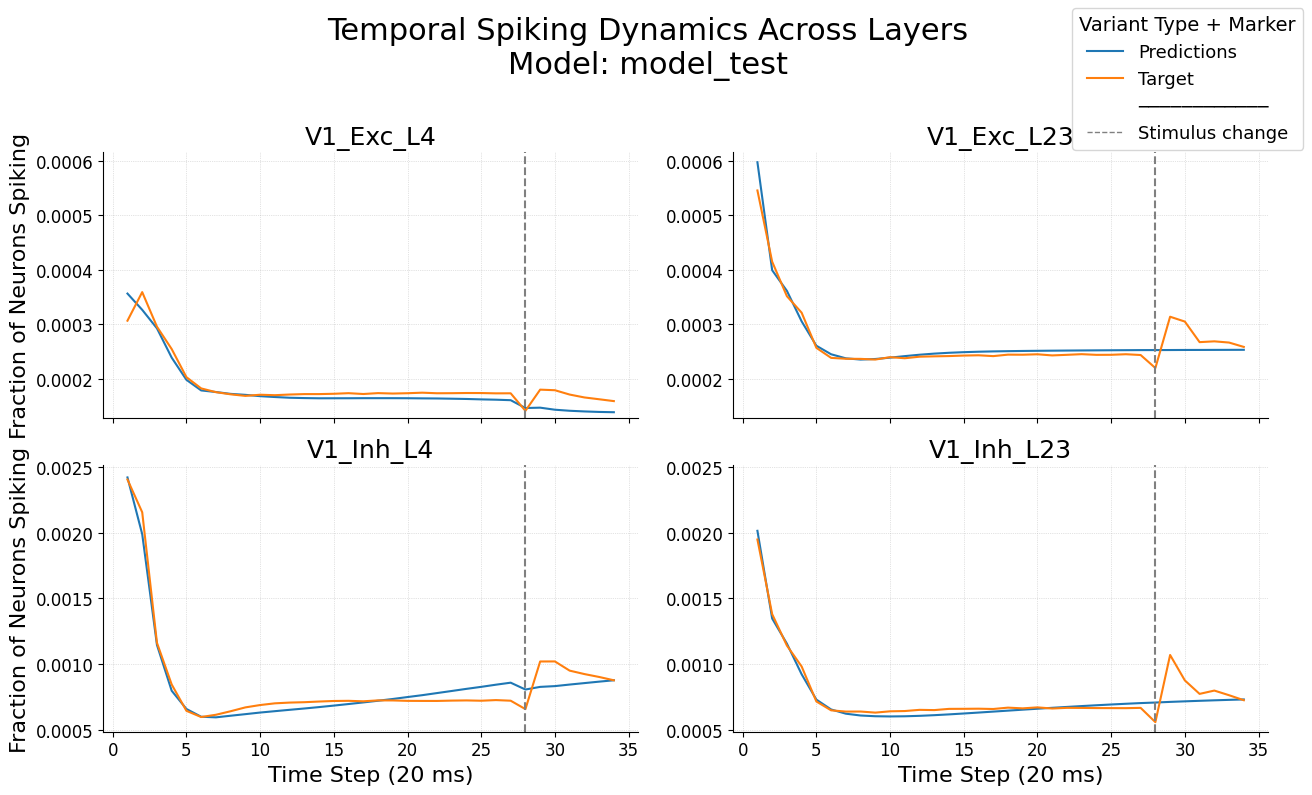

In [34]:
kwargs = {"model_variant": MODEL_VARIANT}
filename = f"separate_model_spiking_curve_{MODEL_VARIANT}.pdf"
destination = f"{WORKFLOW_BASE}{filename}"
ResultsPlotter.plot(all_data, PlottingVariants.SEPARATE_TEMPORAL_BEHAVIOR_TARGET_PREDICTION, save_fig=destination, kwargs=kwargs)